In [89]:
import torch.optim as optim 
from torch.utils.data import DataLoader


In [13]:
import torch
from torchvision import datasets, transforms

# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor()
])

# Download and load the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1000, shuffle=False)


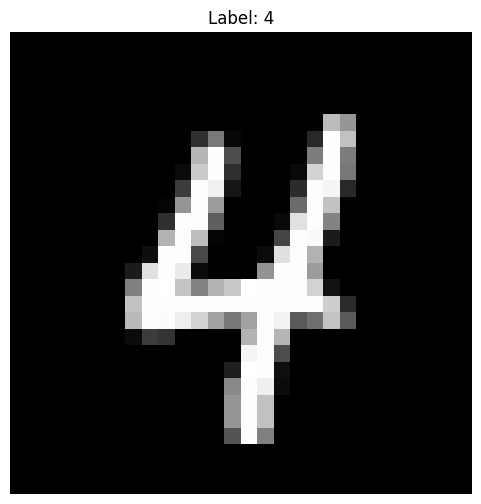

In [14]:
import matplotlib.pyplot as plt

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display the first image in the batch
plt.figure(figsize=(6, 6))
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f'Label: {labels[0].item()}')
plt.axis('off')
plt.show()

In [ ]:
# Implement a series of autoencoders from this chapter leading up to the VAE and VQ.

In [108]:
import torch 
import torch.nn as nn 


class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.ModuleDict({
            'conv1': nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            'conv2': nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            'conv3': nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            'flatten1': nn.Flatten(),
            'fc': nn.Linear(64 * 28 * 28, 10)
        })

        self.decoder = nn.ModuleDict({
            'fc': nn.Linear(10, 64 * 28 * 28),
            'unflatten': nn.Unflatten(1, (64, 28, 28)),
            'conv1': nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            'conv2': nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            'conv3': nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1)
        })

    def forward(self, x):
        for name, layer in self.encoder.items():
            x = layer(x)
            
            if isinstance(layer, nn.Conv2d):
                x = torch.relu(x)
            
        # Decoder
        for layer in self.decoder.values():
            x = layer(x)
            if isinstance(layer, nn.ConvTranspose2d):
                x = torch.relu(x)
            print(x.shape)
        return torch.sigmoid(x)

In [109]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [110]:
model = Autoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data.to(device))
        loss = loss_fn(outputs, data)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

print("Training finished!")

model.eval()
with torch.no_grad():
    # Get a batch of test images
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
    test_images, _ = next(iter(test_loader))
    test_images = test_images.to(device)
    
    # Reconstruct images
    reconstructed = model(test_images)
    
    # Plot original and reconstructed images
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

# Save the model
torch.save(model.state_dict(), 'autoencoder_model.pth')
print("Model saved!")



# Need to fix this tomorrow...need to understand the outputs from conv layers 

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (64x1024 and 50176x10)

In [ ]:
# Implement VAE

In [71]:
# Implement VQ-VAE